In [1]:
import pandas as pd
sle_pro_cox = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/cox3/sle_pro_cox.csv")
sle_pro_5_cox = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/cox3/sle_pro_5_cox.csv")
sle_pro_10_cox = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/cox3/sle_pro_10_cox.csv")
sle_pro_15_cox = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/cox3/sle_pro_15_cox.csv")

sle_pro_cox = sle_pro_cox[sle_pro_cox['Bonferroni']<0.05]
sle_pro_5_cox = sle_pro_5_cox[sle_pro_5_cox['Bonferroni']<0.05]
sle_pro_10_cox = sle_pro_10_cox[sle_pro_10_cox['Bonferroni']<0.05]
sle_pro_15_cox = sle_pro_15_cox[sle_pro_15_cox['Bonferroni']<0.05]

sle_pro_cox_cols = sle_pro_cox["Feature"].tolist()
sle_pro_cox_cols = sle_pro_cox_cols + ["SLE", "fp-SLE",'sex', 'ethnicity']
sle_pro_5_cox_cols = sle_pro_5_cox["Feature"].tolist()
sle_pro_5_cox_cols = sle_pro_5_cox_cols + ["SLE", "fp-SLE",'sex', 'ethnicity']
sle_pro_10_cox_cols = sle_pro_10_cox["Feature"].tolist()
sle_pro_10_cox_cols = sle_pro_10_cox_cols + ["SLE", "fp-SLE",'sex', 'ethnicity']
sle_pro_15_cox_cols = sle_pro_15_cox["Feature"].tolist()
sle_pro_15_cox_cols = sle_pro_15_cox_cols + ["SLE", "fp-SLE",'sex', 'ethnicity']


In [2]:
time_group = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/sle_group.csv")

within_five = time_group[time_group["Group"]=="0-5"]
within_five_eid = within_five["eid"].tolist()

five_ten = time_group[time_group["Group"]=="5-10"]
five_ten_eid = five_ten["eid"].tolist()

ten_fifteen = time_group[time_group["Group"]=="10-15"]
ten_fifteen_eid = ten_fifteen["eid"].tolist()

In [3]:
immune_basic = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/immune_basic_fp.csv")
pro = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/pro_sler")
st_features = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/sle_student_t_features.csv")
immune_pro = pro.merge(immune_basic, on='eid', how='left')
immune_pro = immune_pro.merge(st_features[['eid', 'alcohol_amount']], on='eid', how='left')
unuse_col = ['RA', 'SS', 'Systemic Sclerosis', 'APS', 'Autoimmune thyroiditis', 'icd10_SLE_dates', 'icd10_RA_dates', 'icd10_SS_dates', 'icd10_Systemic Sclerosis_dates', 'icd10_APS_dates', 'icd10_Autoimmune thyroiditis_dates', 'srd_RA', 'srd_SS', 'srd_Systemic Sclerosis', 'srd_APS', 'srd_Autoimmune thyroiditis', 'bmi', 'date_attend', 'birth_year', 'birth_month', 'fp-len', 'fp-RA', 'fp-SS', 'fp-Systemic Sclerosis', 'fp-APS', 'fp-Autoimmune thyroiditis', 'age']
immune_pro.drop(columns=unuse_col, inplace=True)

In [4]:
sle_pro = immune_pro[immune_pro["fp-SLE"] > 0]
sle_pro.drop(["srd_SLE"], axis=1, inplace=True)
sle_pro = sle_pro.fillna(sle_pro.median(numeric_only=True))

sle_pro_5 = sle_pro[sle_pro["eid"].isin(within_five_eid)]
sle_pro_10 = sle_pro[sle_pro["eid"].isin(five_ten_eid)]
sle_pro_15 = sle_pro[sle_pro["eid"].isin(ten_fifteen_eid)]
sle_control = sle_pro[sle_pro["SLE"]==0]
print(sle_pro_5.shape,sle_pro_10.shape,sle_pro_15.shape,sle_control.shape)


/var/folders/sy/n_c36kvx487143mhq4gvc7b40000gn/T/ipykernel_87786/1338989438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sle_pro.drop(["srd_SLE"], axis=1, inplace=True)


(152, 2929) (110, 2929) (13, 2929) (52472, 2929)


In [5]:
sle_pro = sle_pro[sle_pro_cox_cols]
sle_pro_5 = sle_pro_5[sle_pro_5_cox_cols]
sle_pro_10 = sle_pro_10[sle_pro_10_cox_cols]
sle_pro_15 = sle_pro_15[sle_pro_15_cox_cols]

In [6]:
sle_pro.columns = sle_pro.columns.str.upper()
sle_pro

,ACP5,ACVRL1,ACY3,ADA2,ADAM8,ADAM9,ADAMTS13,ADAMTS4,ADAMTSL2,ADGRE1,...,WARS,WFDC2,XPNPEP2,YAP1,ZBP1,ZBTB17,SLE,FP-SLE,SEX,ETHNICITY
0,-0.20560,-0.0927,0.5754,-0.35760,0.0648,-0.44145,-0.21725,-0.1705,-0.5375,-0.42585,...,0.00940,-0.1635,-0.74150,-0.0127,-0.26195,-0.15940,0,14.442163,1.0,1001.0
1,-0.01390,-0.1653,0.4553,0.57840,0.8715,0.06105,-0.38695,0.1946,0.3227,0.43395,...,0.67220,-0.1195,0.27110,0.0991,0.04325,0.08600,0,13.075975,0.0,1001.0
2,-0.05630,0.0616,0.8745,-0.75790,-0.4429,-0.13125,-0.13395,-0.0974,-0.2384,-0.31065,...,-0.24600,-0.2508,-0.49670,0.0016,-0.03085,-0.00810,0,13.631759,0.0,1001.0
3,-0.39200,0.0887,0.1126,0.46210,0.4413,0.64475,0.07705,-0.0032,-0.3367,2.21355,...,0.01650,0.0051,0.20980,0.0753,-0.14735,-0.43730,0,15.208761,0.0,1001.0
4,0.50090,0.0123,0.3779,0.15550,0.6922,0.35995,-0.16265,0.0356,0.1940,1.09575,...,0.54480,0.1512,-1.74880,0.5318,0.54105,1.13460,0,15.301848,1.0,1001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53008,0.04930,0.3051,0.2771,0.51810,0.3682,0.11165,-0.04935,0.8166,-0.2076,0.48365,...,-0.08690,0.3291,-2.04200,0.0031,-0.13435,-0.00310,0,14.869268,0.0,1001.0
53009,0.93475,0.3557,0.0000,0.51185,0.4354,0.00415,-0.30770,0.0000,0.0000,0.00425,...,0.19695,-0.0020,0.02035,0.0070,-0.00065,0.14665,0,16.355921,1.0,1001.0
53010,-0.44625,-0.2516,0.0000,0.01725,-0.5565,0.00415,0.39200,0.0000,0.0000,0.00425,...,-0.68995,0.0550,-1.33415,0.0070,-0.00065,0.24585,0,15.641342,0.0,1003.0
53011,0.40160,0.3928,-0.3921,-0.04910,-0.4302,-0.19425,0.21250,0.4267,0.1065,0.78995,...,0.07090,0.0081,-1.44830,-0.2159,0.16935,-0.27030,0,15.531828,0.0,4001.0


In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

def analyze_protein_trajectories(data, protein_cols, covariates, case_col='SLE', time_col='fp-SLE', n_matches=10, loess_frac=0.3):

    result = {}
    corrected_data = data.copy()
    for protein in protein_cols:
        model = LinearRegression()
        X = data[covariates]
        y = data[protein]
        model.fit(X, y)
        corrected_data[protein] = y - model.predict(X)
    result['corrected_data'] = corrected_data
    
    cases = corrected_data[corrected_data[case_col] == 1]
    controls = corrected_data[corrected_data[case_col] == 0]
    nbrs = NearestNeighbors(n_neighbors=n_matches).fit(controls[covariates])
    distances, indices = nbrs.kneighbors(cases[covariates])
    matched_controls = {case_idx: controls.iloc[indices[i]].index.tolist() for i, case_idx in enumerate(cases.index)}

    z_scores = pd.DataFrame(index=matched_controls.keys(), columns=protein_cols)
    for case_idx, control_indices in matched_controls.items():
        for protein in protein_cols:
            control_values = corrected_data.loc[control_indices, protein]
            z = (corrected_data.loc[case_idx, protein] - control_values.mean()) / control_values.std()
            z_scores.loc[case_idx, protein] = z
    result['z_scores'] = z_scores

    loess_results = {}
    time_min = 0
    time_max = 15
    time_points = np.arange(time_min, time_max + 0.05, 0.05)

    for protein in protein_cols:
        x = data.loc[z_scores.index, time_col]
        y = z_scores[protein].dropna()
        if len(y) > 0:
            loess = sm.nonparametric.lowess
            fitted_values = loess(y, x, frac=loess_frac)
            loess_interpolated = np.interp(time_points, fitted_values[:, 0], fitted_values[:, 1])
            loess_results[protein] = np.column_stack((time_points, loess_interpolated))
    result['loess_results'] = loess_results

    loess_df = pd.DataFrame({
        protein: res[:, 1] if res is not None else [float('nan')] * len(time_points)
        for protein, res in loess_results.items()
    }).T

    loess_df = loess_df.dropna(axis=1).astype(float)
    dist_matrix = pdist(loess_df, metric='euclidean')  
    linkage_matrix = linkage(dist_matrix, method='ward') 

    if len(loess_df) > 1:  
        dist_matrix_square = squareform(dist_matrix) 
        max_clusters = min(len(loess_df) - 1, 10)  
        silhouette_scores = []

        for k in range(2, max_clusters + 1):
            labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
            score = silhouette_score(dist_matrix_square, labels, metric='precomputed')
            silhouette_scores.append(score)

        if silhouette_scores: 
            optimal_k = np.argmax(silhouette_scores) + 2 
            cluster_labels = fcluster(linkage_matrix, t=optimal_k, criterion='maxclust')
            result['optimal_n_clusters'] = optimal_k
            result['clusters'] = {protein: label for protein, label in zip(loess_df.index, cluster_labels)}
        else:
            cluster_labels = fcluster(linkage_matrix, t=2, criterion='maxclust')
            result['optimal_n_clusters'] = 2
            result['clusters'] = {protein: label for protein, label in zip(loess_df.index, cluster_labels)}
    else:
        result['optimal_n_clusters'] = 1
        result['clusters'] = {protein: 1 for protein in loess_df.index}

    result['linkage_matrix'] = linkage_matrix 

    return result


In [12]:

col_1 = [col.upper() for col in ['eid', 'SLE', 'fp-SLE', 'sex', 'ethnicity', 'alcohol_amount']]

protein_cols = [col for col in sle_pro.columns if col not in col_1]
covariates = [col.upper() for col in ['sex', 'ethnicity']]

result_5 = analyze_protein_trajectories(
    data=sle_pro,
    protein_cols=protein_cols,
    covariates=covariates,
    case_col='SLE',
    time_col='FP-SLE',
    n_matches=10,
    loess_frac=0.3,
)


In [14]:
result_5['corrected_data'].to_csv("/Volumes/data_files/UKB_data/immune_result/loess3/sle_pro_corrected_data.csv", index=True)
result_5['z_scores'].to_csv("/Volumes/data_files/UKB_data/immune_result/loess3/sle_pro_z_scores.csv", index=True)
pd.DataFrame(result_5['clusters'], index=['Cluster']).T.to_csv("/Volumes/data_files/UKB_data/immune_result/loess3/sle_pro_clusters.csv", index=True)

In [15]:
import pandas as pd
loess_results = result_5['loess_results']
x_values = list(loess_results.values())[0][:, 0] 
df_loess = pd.DataFrame({"x": x_values})
for protein, values in loess_results.items():
    df_loess[protein] = values[:, 1]
df_loess.to_csv("/Volumes/data_files/UKB_data/immune_result/loess3/sle_pro_loess_results.csv", index=False)

/var/folders/sy/n_c36kvx487143mhq4gvc7b40000gn/T/ipykernel_87786/181106601.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_loess[protein] = values[:, 1]
/var/folders/sy/n_c36kvx487143mhq4gvc7b40000gn/T/ipykernel_87786/181106601.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_loess[protein] = values[:, 1]
/var/folders/sy/n_c36kvx487143mhq4gvc7b40000gn/T/ipykernel_87786/181106601.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

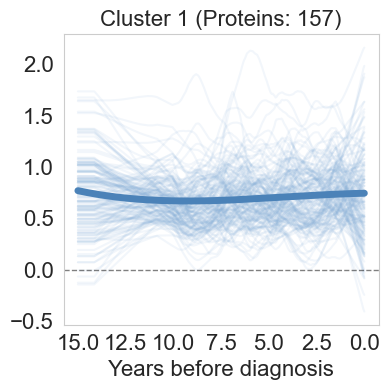

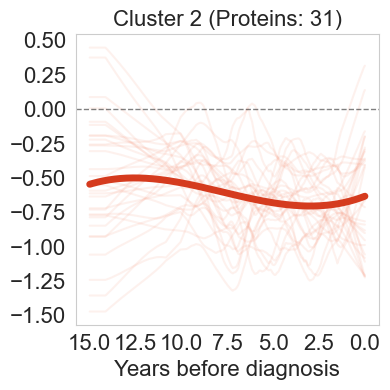

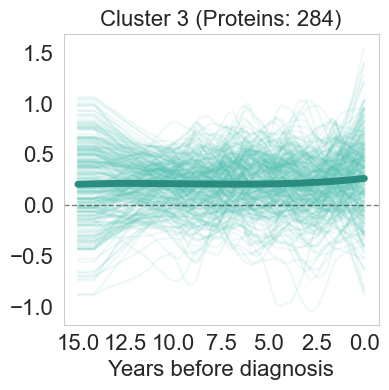

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
moranthi_colors = ['#81acd8', '#f47958', '#53c4b5', '#a891cc', '#fca550']
moranthi_loess_colors = ['#4b82b8', '#d53b1e', '#2a8b7f', '#7a5fa6', '#c47b00']

def plot_cluster_fitting_with_moranthi_separate(result, n_clusters, time_col='fp-SLE'):
    loess_results = result['loess_results']
    clusters = result['clusters']
    cluster_groups = {i: [] for i in range(1, n_clusters+1)}

    for protein, cluster in clusters.items():
        cluster_groups[cluster].append(protein)

    for cluster, proteins in cluster_groups.items():
        plt.figure(figsize=(4, 4))
        num_proteins = len(proteins)
        plt.title(f'Cluster {cluster} (Proteins: {num_proteins})', fontsize=16)
        all_z_scores = []
        for protein in proteins:
            if protein in loess_results:
                loess_data = loess_results[protein]
                z_scores = loess_data[:, 1]  
                all_z_scores.append(z_scores)

        if all_z_scores:
            avg_z_scores = np.mean(all_z_scores, axis=0)

            for protein in proteins:
                if protein in loess_results:
                    loess_data = loess_results[protein]
                    plt.plot(loess_data[:, 0], loess_data[:, 1], color=moranthi_colors[cluster-1], alpha=0.1) 

            loess_x = loess_data[:, 0]
            spline = UnivariateSpline(loess_x, avg_z_scores, s=0.6)
            plt.plot(loess_x, spline(loess_x), label=f'Spline Fit for Cluster {cluster}', color=moranthi_loess_colors[cluster-1], linewidth=5)

        plt.gca().invert_xaxis()
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel('Years before diagnosis', fontsize=16)
        plt.grid(False)
        plt.axhline(y=0, color='black', linewidth=1, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.savefig(f"Cluster_{cluster}_protein.pdf", format='pdf')
        # plt.show()


# 调用函数绘制聚类表达的样条拟合结果
plot_cluster_fitting_with_moranthi_separate(result_5, n_clusters=3)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd  # Make sure to import pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loess_heatmap(loess_results, time_col, clusters=None):
    loess_df = pd.DataFrame({
        protein: pd.Series({t: v for t, v in res})
        for protein, res in loess_results.items()
        if res is not None
    }).fillna(0)

    if clusters:
        sorted_proteins = sorted(clusters.keys(), key=lambda x: clusters[x])
        loess_df = loess_df[sorted_proteins]

    plt.figure(figsize=(16, 8))  
    sns.heatmap(
        loess_df.T,
        cmap="RdBu_r",
        center=0,
        cbar_kws={'label': 'Z-score'},
        xticklabels=np.round(loess_df.index, 1),
        yticklabels=False, 
        vmin=-1.5,           
        vmax=1.5             
    )
    plt.xlabel('Years before diagnosis', fontsize=16)

    target_ticks = np.linspace(15, 0, num=6, dtype=float) 
    xticks_positions = [np.argmin(np.abs(loess_df.index - t)) for t in target_ticks]
    plt.xticks(xticks_positions, target_ticks, rotation=0)

    plt.ylabel('Proteins', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.gca().invert_xaxis()

    plt.tight_layout()
    plt.savefig("Protein trajectories.pdf", format='pdf')
    plt.show()
    plt.close()

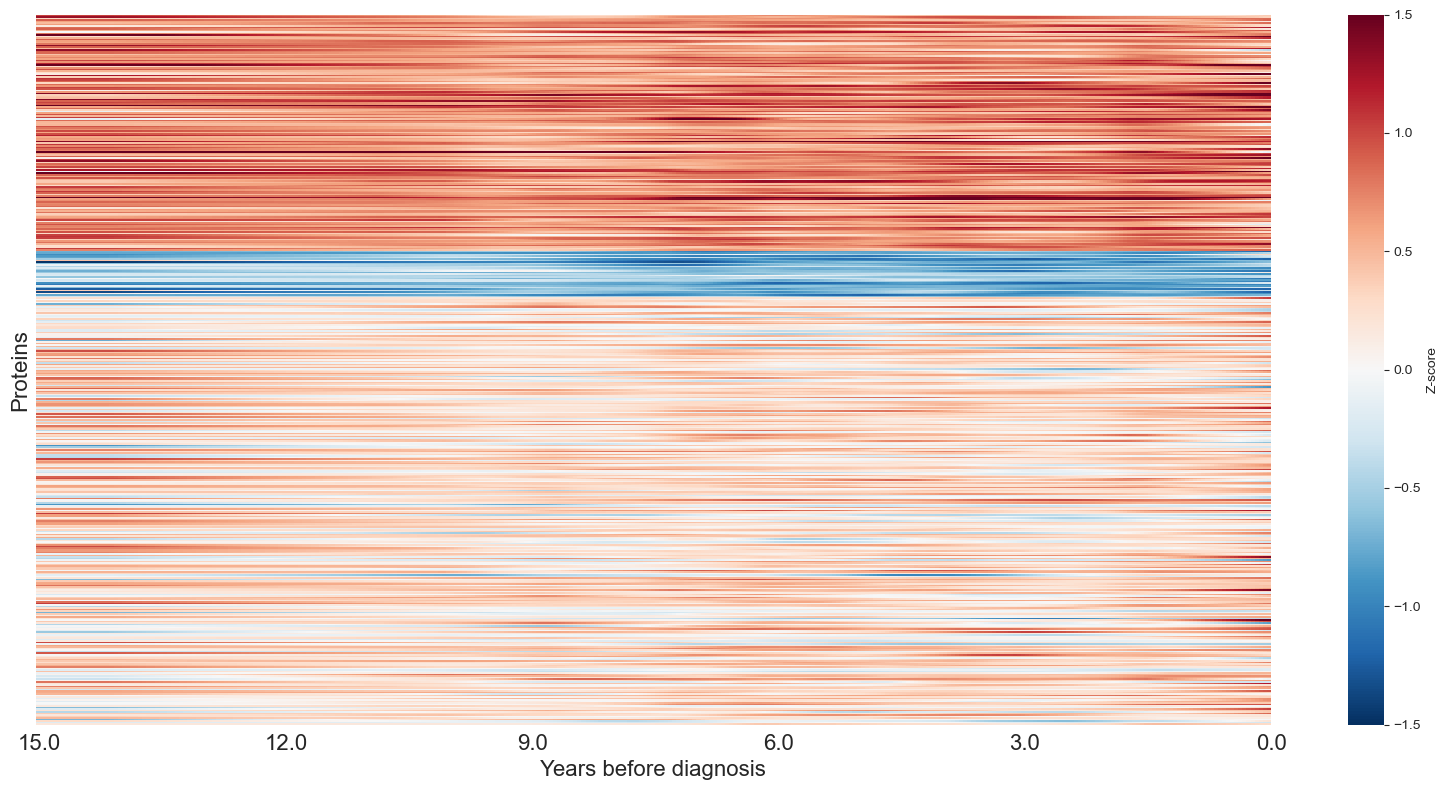

In [19]:
plot_loess_heatmap(result_5['loess_results'], time_col='fp-SLE', clusters=result_5['clusters'])

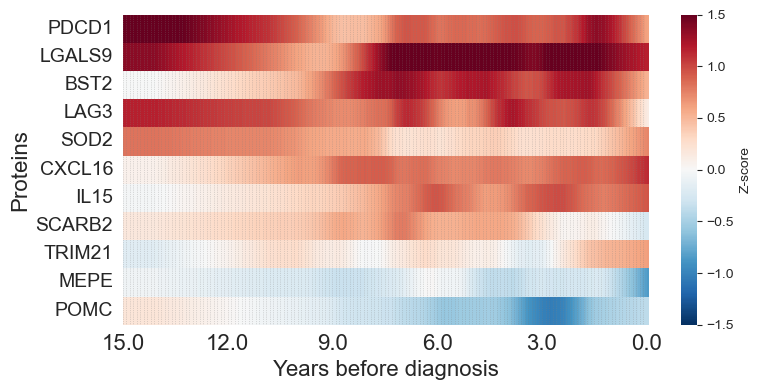

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def selected_plot_loess_heatmap(loess_results, clusters=None):
    selected_proteins = [protein.upper() for protein in [
        'pdcd1', 'lgals9', 'bst2', 'lag3', 'il15', 'sod2', 'scarb2', 'cxcl16', 'trim21', 'mepe', 'pomc'
    ]]

    filtered_results = {protein: loess_results[protein] for protein in selected_proteins if protein in loess_results}

    if not filtered_results:
        raise ValueError("No valid LOESS results for the selected proteins.")

    loess_df = pd.DataFrame({
        protein: pd.Series({t: v for t, v in res})
        for protein, res in filtered_results.items()
    }).fillna(0)

    if clusters:
        sorted_proteins = sorted(selected_proteins, key=lambda x: clusters.get(x, float('inf')))
        loess_df = loess_df[sorted_proteins]

    loess_df = loess_df.sort_index(ascending=False)

    if loess_df.empty:
        raise ValueError("LOESS results contain no valid data for plotting.")

    plt.figure(figsize=(8, 4))
    ax = sns.heatmap(
        loess_df.T,
        cmap="RdBu_r",
        center=0,
        cbar_kws={'label': 'Z-score'},
        xticklabels=False,  
        yticklabels=loess_df.columns, 
        vmin=-1.5, 
        vmax=1.5
    )

    target_ticks = np.linspace(15, 0, num=6, dtype=float)
    xticks_positions = [np.argmin(np.abs(loess_df.index - t)) for t in target_ticks]
    plt.xticks(xticks_positions, target_ticks, rotation=0)

    minor_ticks = np.arange(15, 0, -0.1) 
    minor_positions = [np.argmin(np.abs(loess_df.index - t)) for t in minor_ticks]

    for pos in minor_positions:
        ax.axvline(x=pos, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.minorticks_on()
    ax.xaxis.set_minor_locator(plt.FixedLocator(minor_positions)) 
    ax.grid(visible=True, which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.5) 

    plt.xlabel('Years before diagnosis', fontsize=16)
    plt.ylabel('Proteins', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.savefig("Selected Protein trajectories.pdf", format='pdf')
    plt.show()
    plt.close()

selected_plot_loess_heatmap(result_5['loess_results'], clusters=result_5['clusters'])